**Name:** Jaykumar Darji \
**Subject:** EE258 - Neural Networks \
**Department of Electrical Engineering** \
**San Jose State University**


# Indian Pines Hyperspectral Image
## Exploratory Data Analysis and Visualization

This notebook explores the Indian Pines hyperspectral image. It covers loading data, quick sanity checks, summary statistics, label distribution, visualizations of bands and an RGB composite, spectral signatures, dimensionality reduction with PCA and t SNE, band correlation, and outlier detection.

**How to use this file**
1. Place the dataset files next to this notebook or use a Kaggle path if you run it on Kaggle.
2. Run the cells from top to bottom.
3. If your data uses different file names, edit the loader section.


---
#### What is a hyperspectral image? 
A hyperspectral image is a three-dimensional dataset that captures light reflectance information across many narrow, contiguous spectral bands for each pixel in a scene. Unlike a regular RGB image (which has 3 bands: red, green, and blue), a hyperspectral image can have hundreds of bands—typically between 100 and 300.

**Dataset Description**

The **Indian Pines** dataset is a benchmark hyperspectral image widely used for research in image classification, feature extraction, and spectral analysis. It was collected by NASA’s **AVIRIS (Airborne Visible/Infrared Imaging Spectrometer)** sensor over **northwestern Indiana, USA**, and contains a mix of agricultural and natural land-cover types.

**1. Dataset Characteristics**

- **Spatial dimensions:** 145 × 145 pixels  
- **Spectral bands:** 224 originally, reduced to **200** after removing noisy water absorption bands (104–108, 150–163, and 220)  
- **Spectral range:** 0.4 to 2.5 micrometers (visible to shortwave infrared)  
- **Sensor:** AVIRIS (Airborne Visible/Infrared Imaging Spectrometer)  
- **Data type:** Surface reflectance values (floating-point)  

Each pixel records a **spectral signature** — a reflectance value at each of 200 wavelengths — making the data three-dimensional `(height × width × bands)`.

**2. Scene Description**

- The scene includes **agricultural fields**, **forest areas**, and some **urban features**.  
- Approximately **two-thirds of the area** is agricultural, while the rest is forest or other natural vegetation.  
- It also contains **roads, railways, small buildings,** and **low-density residential zones**.  
- Captured in **June**, when crops like *corn* and *soybeans* were in their **early growth stages** (less than 5% canopy cover).

**3. Ground Truth and Land-Cover Classes**

The dataset includes a **ground truth map** that labels **16 distinct land-cover classes**.  
Each class represents a specific crop type or land-cover condition.

| Class ID | Class Name | Description |
|-----------|-------------|-------------|
| 1 | Alfalfa | Crop field |
| 2 | Corn no till | Corn with minimal soil tillage |
| 3 | Corn min till | Corn with moderate tillage |
| 4 | Corn | Regular corn fields |
| 5 | Grass pasture | Grassland for grazing |
| 6 | Grass trees | Grassy areas with trees |
| 7 | Grass pasture mowed | Recently cut grass |
| 8 | Hay windrowed | Dried hay fields |
| 9 | Oats | Oat fields |
| 10 | Soybeans no till | Soybeans with no soil disturbance |
| 11 | Soybeans min till | Soybeans with moderate tillage |
| 12 | Soybeans clean | Fully tilled soybean fields |
| 13 | Wheat | Wheat crop |
| 14 | Woods | Forested regions |
| 15 | Buildings grass trees drives | Mixed urban and vegetation area |
| 16 | Stone steel towers | Small man-made structures |

**4. Label Distribution**

- **Total pixels:** 145 × 145 = 21,025  
- **Labeled pixels:** 10,249 (~49%)  
- **Unlabeled pixels:** Represent background or unknown regions  
- **Classes:** 16 distinct land-cover types

**5. Applications**

The Indian Pines dataset is widely used for:

- Hyperspectral **image classification** (e.g., crop type mapping)  
- **Dimensionality reduction** (e.g., PCA, LDA, or band selection)  
- **Clustering** and **feature extraction**  
- Testing **machine learning** and **deep learning** algorithms in remote sensing  

**6. Summary**

| Property | Details |
|-----------|----------|
| **Dataset name** | Indian Pines |
| **Location** | Northwestern Indiana, USA |
| **Dimensions** | 145 × 145 × 200 |
| **Spectral range** | 0.4–2.5 µm |
| **Sensor** | AVIRIS |
| **Classes** | 16 |
| **Total pixels** | 21,025 |
| **Labeled pixels** | 10,249 |


---
#### Importing Required Libraries and Setting Up the Environment
- This section imports all necessary Python libraries for data loading, processing, visualization, and analysis, while also setting random seeds for reproducibility and suppressing unnecessary warnings.

In [1]:
import os
import sys
import math
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat

warnings.filterwarnings("ignore")

np.random.seed(42)
random.seed(42)

print("Python", sys.version)
print("NumPy", np.__version__)
print("Pandas", pd.__version__)
print("Matplotlib", plt.matplotlib.__version__)


Python 3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]
NumPy 2.0.2
Pandas 2.2.2
Matplotlib 3.9.2


---
#### Loading and Preparing the Indian Pines Hyperspectral Dataset
- This code automatically loads the Indian Pines hyperspectral image and ground truth labels from either local .mat files or Kaggle sources, removes noisy water absorption bands, fixes invalid values, and prepares the data for analysis by ensuring shape consistency and creating a labeled pixel mask.

In [2]:
def _try_load_mat(mat_path: Path):
    if not mat_path.exists():
        return None
    data = loadmat(mat_path.as_posix())
                                                                                                                   # Try common keys    for key in ["indian_pines_corrected", "indian_pines", "data", "X"]:
        if key in data:
            return data[key]
                                                                                                                   # Fallback to first 3D array found    for k, v in data.items():
        if isinstance(v, np.ndarray) and v.ndim == 3:
            return v
    return None

def _try_load_gt(gt_path: Path):
    if not gt_path.exists():
        return None
    data = loadmat(gt_path.as_posix())
    for key in ["indian_pines_gt", "gt", "y"]:
        if key in data:
            return data[key]
                                                                                                                   # Fallback to first 2D array found    for k, v in data.items():
        if isinstance(v, np.ndarray) and v.ndim == 2:
            return v
    return None

def load_indian_pines():
    """Try to load Indian Pines data and labels from common locations.
    Returns
        hsi: np.ndarray of shape (H, W, B)
        gt:  np.ndarray of shape (H, W) with 0 for unlabeled
        source: str description of where the data came from
    """
                                                                                                                   # Option A: Kaggle dataset with npy files    kaggle_npy_data = Path('/kaggle/input/indian-pines-hyperspectral-dataset/indianpinearray.npy')
    kaggle_npy_gt   = Path('/kaggle/input/indian-pines-hyperspectral-dataset/IPgt.npy')
    if kaggle_npy_data.exists() and kaggle_npy_gt.exists():
        hsi = np.load(kaggle_npy_data.as_posix())
        gt  = np.load(kaggle_npy_gt.as_posix())
        return hsi, gt, "Kaggle npy files"

                                                                                                                   # Option B: MATLAB corrected files in current working directory    local_mat_data = Path('Indian_pines_corrected.mat')
    local_mat_gt   = Path('Indian_pines_gt.mat')
    hsi = _try_load_mat(local_mat_data)
    gt  = _try_load_gt(local_mat_gt)
    if hsi is not None and gt is not None:
        return hsi, gt, "Local MATLAB corrected files"

                                                                                                                   # Option C: look for any .mat files under current folder and try load    for root, dirs, files in os.walk('.', topdown=True):
        mats = [f for f in files if f.lower().endswith('.mat')]
        if mats:
            data_path = None
            gt_path = None
            for f in mats:
                lower = f.lower()
                if "gt" in lower or "ground" in lower or "labels" in lower:
                    gt_path = Path(root) / f
                else:
                    data_path = Path(root) / f
            if data_path:
                hsi = _try_load_mat(Path(data_path))
            if gt_path:
                gt = _try_load_gt(Path(gt_path))
            if hsi is not None and gt is not None:
                return hsi, gt, f"Auto detected .mat files under {root}"

    raise FileNotFoundError(
        "Could not find dataset. Place Indian_pines_corrected.mat and Indian_pines_gt.mat next to this notebook "
        "or attach the Kaggle dataset 'Indian Pines Hyperspectral Dataset' to the notebook."
    )

hsi, gt, source = load_indian_pines()

print("Loaded from:", source)
print("HSI shape:", hsi.shape, "dtype:", hsi.dtype)
print("GT shape:", gt.shape, "dtype:", gt.dtype)

                                                                                                                   # Ensure shapes are consistentassert hsi.ndim == 3, "HSI must be H x W x B"
assert gt.ndim == 2, "GT must be H x W"
assert hsi.shape[:2] == gt.shape[:2], "Spatial shape mismatch"

H, W, B = hsi.shape

                                                                                                                   # Remove water absorption bands if present and if B >= 220drop_idx = list(range(103, 108)) + list(range(149, 163)) + [219]                                                   # zero basedif B >= 220:
    keep_mask = np.ones(B, dtype=bool)
    keep_mask[drop_idx] = False
    hsi = hsi[..., keep_mask]
    B = hsi.shape[-1]
    print("Removed water absorption bands. New bands:", B)
else:
    print("No band removal applied. Bands:", B)

                                                                                                                   # Replace NaN or inf if anybad = ~np.isfinite(hsi)
if bad.any():
    print("Found NaN or inf in HSI. Replacing with band medians.")
    flat = hsi.reshape(-1, B)
    med = np.nanmedian(flat, axis=0)
    flat[~np.isfinite(flat)] = np.take(med, np.where(~np.isfinite(flat))[1])
    hsi = flat.reshape(H, W, B)

                                                                                                                   # Convert to float32 for speedhsi = hsi.astype(np.float32, copy=False)

                                                                                                                   # Make a mask for labeled pixelsmask_labeled = gt > 0

print("Total pixels:", H*W)
print("Labeled pixels:", int(mask_labeled.sum()))


Loaded from: Auto detected .mat files under .\data
HSI shape: (512, 217, 204) dtype: int16
GT shape: (512, 217) dtype: uint8
No band removal applied. Bands: 204
Total pixels: 111104
Labeled pixels: 54129


---
#### Checking Data Range and Band-wise Statistics
- This code prints the overall minimum and maximum reflectance values of the hyperspectral image and lists the per-band minimum and maximum values for the first five spectral bands to verify data consistency and detect any anomalies or scaling issues.

In [3]:

print("HSI min:", np.nanmin(hsi), "max:", np.nanmax(hsi))
print("Per band min and max for first 5 bands:")
mins = hsi.reshape(-1, B).min(axis=0)[:5]
maxs = hsi.reshape(-1, B).max(axis=0)[:5]
print("mins:", np.round(mins, 4))
print("maxs:", np.round(maxs, 4))


HSI min: -11.0 max: 9207.0
Per band min and max for first 5 bands:
mins: [87. 86. 90. 86. 91.]
maxs: [ 814. 1165. 1920. 3865. 5153.]


In [4]:

def percentile_stretch(img2d, low=2, high=98):
    a = np.percentile(img2d, low)
    b = np.percentile(img2d, high)
    if b <= a:
        return np.clip(img2d, a, b)
    out = (img2d - a) / (b - a + 1e-6)
    out = np.clip(out, 0, 1)
    return out

def show_band(img3d, band_index, title=None):
    arr = percentile_stretch(img3d[:, :, band_index])
    plt.figure(figsize=(5,5))
    plt.imshow(arr)
    plt.title(title if title else f"Band {band_index}")
    plt.axis('off')
    plt.show()

def make_rgb(img3d, r, g, b):
    r_img = percentile_stretch(img3d[:, :, r])
    g_img = percentile_stretch(img3d[:, :, g])
    b_img = percentile_stretch(img3d[:, :, b])
    rgb = np.stack([r_img, g_img, b_img], axis=-1)
    rgb = np.clip(rgb, 0, 1)
    return rgb


---
#### Visualization of different spectral bands 

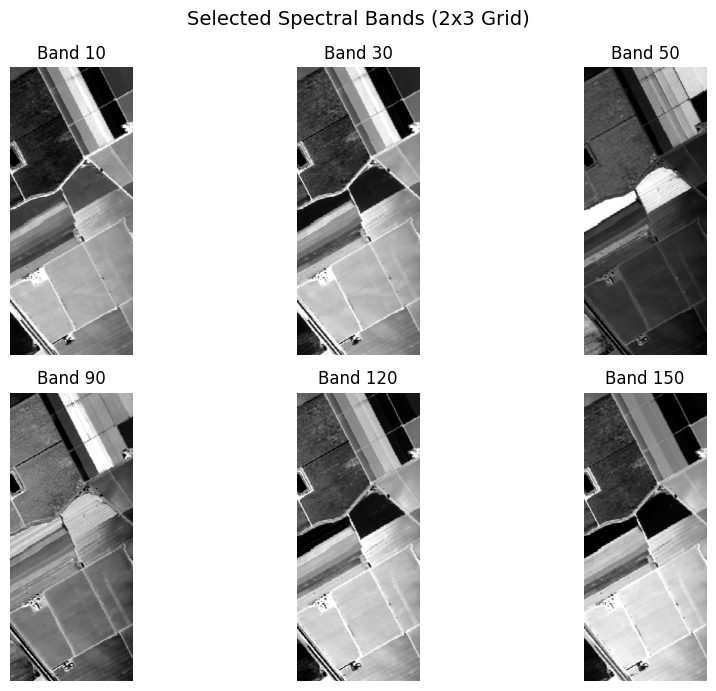

In [5]:
                                                                 # Show Bands (2x3 Subplot Visualization)                                                                 # Display six selected spectral bands using the existing show_band() helper
selected_bands = [10, 30, 50, 90, 120, 150] if B > 150 else [
    max(0, int(B * 0.1)),
    max(0, int(B * 0.2)),
    max(0, int(B * 0.3)),
    max(0, int(B * 0.5)),
    max(0, int(B * 0.7)),
    max(0, int(B * 0.9))
]

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes = axes.ravel()

for i, idx in enumerate(selected_bands[:6]):
    idx = int(np.clip(idx, 0, B - 1))
    band_img = percentile_stretch(hsi[:, :, idx])
    axes[i].imshow(band_img, cmap='gray')
    axes[i].set_title(f'Band {idx}')
    axes[i].axis('off')

plt.suptitle('Selected Spectral Bands (2x3 Grid)', fontsize=14)
plt.tight_layout()
plt.show()


---
#### Plotting the pseudo RGB image
- This is called a false color composite because the chosen bands don’t correspond exactly to human visible colors.
- It helps reveal features like vegetation, soil, water, or roads, which might not be obvious in grayscale bands.

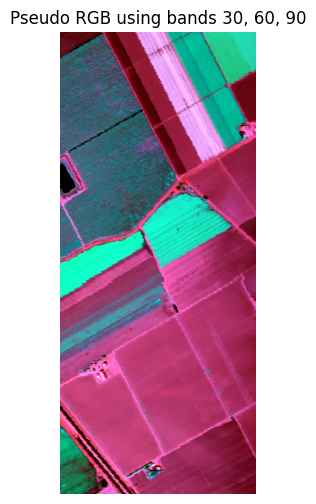

In [6]:

                                                            # Choose three bands spread across spectrum for a pseudo RGB lookr_i = min(30, B-1)
g_i = min(60, B-1)
b_i = min(90, B-1)

rgb = make_rgb(hsi, r_i, g_i, b_i)
plt.figure(figsize=(6,6))
plt.imshow(rgb)
plt.title(f"Pseudo RGB using bands {r_i}, {g_i}, {b_i}")
plt.axis('off')
plt.show()


---
#### Display the ground truth map
- Each color represents one of the 16 ground truth classes (e.g., Corn, Soybeans, Woods, etc.).
- The black or dark background usually represents unlabeled pixels (class 0).

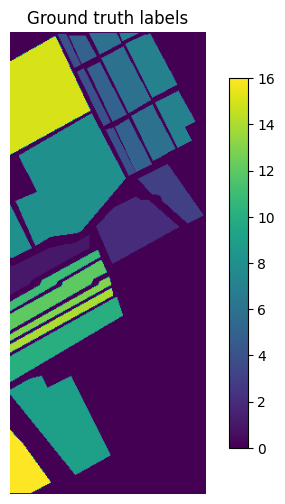

In [7]:

plt.figure(figsize=(6,6))
plt.imshow(gt)
plt.title("Ground truth labels")
plt.axis('off')
plt.colorbar(shrink=0.8)
plt.show()

---
#### visualization of the class distribution
- Counts how many pixels belong to each ground truth class.
- Maps each class to a human-readable name.
- Displays a table and a bar chart of class frequencies.
- Helps you understand data imbalance and class coverage before training.

,class_id,class_name,count
0,8,Hay windrowed,11271
1,15,Buildings grass trees drives,7268
2,9,Oats,6203
3,6,Grass trees,3959
4,2,Corn no till,3726
5,7,Grass pasture mowed,3579
6,10,Soybeans no till,3278
7,5,Grass pasture,2678
8,1,Alfalfa,2009
9,3,Corn min till,1976


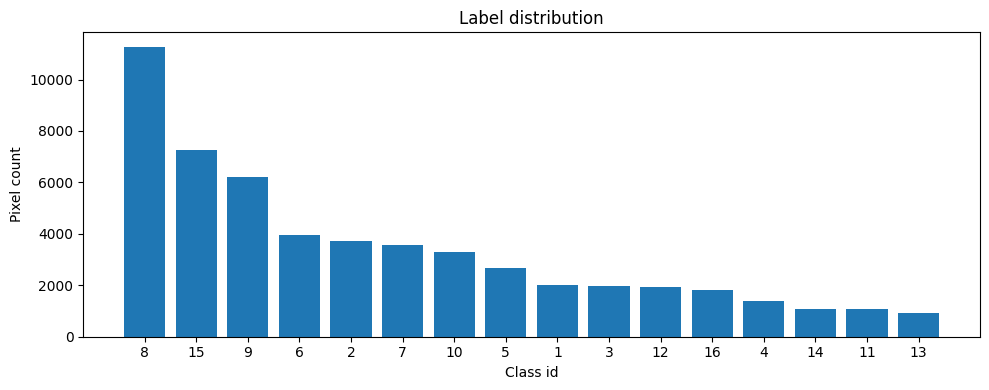

In [8]:

labels, counts = np.unique(gt[gt > 0], return_counts=True)
label_names = {
    1:"Alfalfa", 2:"Corn no till", 3:"Corn min till", 4:"Corn",
    5:"Grass pasture", 6:"Grass trees", 7:"Grass pasture mowed",
    8:"Hay windrowed", 9:"Oats", 10:"Soybeans no till",
    11:"Soybeans min till", 12:"Soybeans clean", 13:"Wheat",
    14:"Woods", 15:"Buildings grass trees drives", 16:"Stone steel towers"
}

df_labels = pd.DataFrame({
    "class_id": labels,
    "class_name": [label_names.get(int(x), f"Class {int(x)}") for x in labels],
    "count": counts
}).sort_values("count", ascending=False).reset_index(drop=True)

display(df_labels)

plt.figure(figsize=(10,4))
plt.bar([str(int(x)) for x in df_labels['class_id']], df_labels['count'])
plt.title("Label distribution")
plt.xlabel("Class id")
plt.ylabel("Pixel count")
plt.tight_layout()
plt.savefig("label_distribution.png", dpi=300)
plt.show()


---
#### Quantitative summary of all 200 spectral bands.
**These insights help us decide:**
- Whether to normalize or scale the data
- Which bands to keep or drop for modeling
- How reflectance varies across the wavelength range for your scene

,band,mean,std,min,max,median
0,0,372.141785,62.448837,87.0,814.0,372.0
1,1,480.379547,80.606300,86.0,1165.0,482.0
2,2,693.780029,103.218819,90.0,1920.0,721.0
3,3,1156.587646,170.673553,86.0,3865.0,1174.0
4,4,1462.257080,227.873596,91.0,5153.0,1496.0


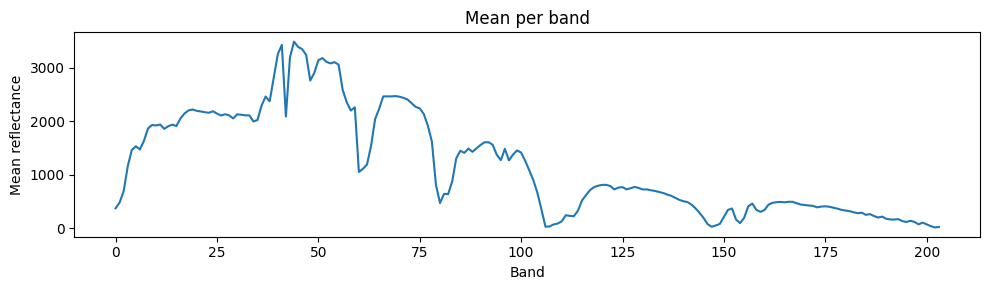

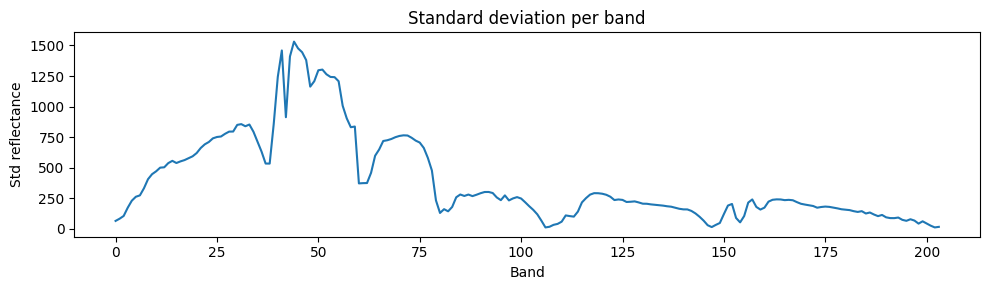

In [9]:
flat = hsi.reshape(-1, B)
band_mean = flat.mean(axis=0)
band_std  = flat.std(axis=0)
band_min  = flat.min(axis=0)
band_max  = flat.max(axis=0)
band_median = np.median(flat, axis=0)

df_stats = pd.DataFrame({
    "band": np.arange(B),
    "mean": band_mean,
    "std": band_std,
    "min": band_min,
    "max": band_max,
    "median": band_median
})
display(df_stats.head())

plt.figure(figsize=(10,3))
plt.plot(df_stats["band"], df_stats["mean"])
plt.title("Mean per band")
plt.xlabel("Band")
plt.ylabel("Mean reflectance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(df_stats["band"], df_stats["std"])
plt.title("Standard deviation per band")
plt.xlabel("Band")
plt.ylabel("Std reflectance")
plt.tight_layout()
plt.show()


**Mean per band**: This line shows average reflectance vs. wavelength (band number).

The shape of this curve represents the average spectral signature of the whole image. 
- The rising part (bands 10–50) shows where vegetation strongly reflects light — this is the near-infrared region (around 0.7–1.3 µm), which is typical for healthy plants.
- The sharp dips (around bands 55, 75 and near 100) correspond to water absorption bands, where the atmosphere absorbs light and reflectance values drop.
- The decline after band 100 shows that the shortwave infrared region (1.5–2.5 µm) has lower reflectance for vegetation and soil.
- The flat low region after about band 150 indicates low sensor response or less information content.

**Standard deviation per band**: This line shows how much pixel values vary across the image for each band.

- High standard deviation = high contrast or variability among materials (for example, crops vs. soil).
- Low standard deviation = uniform reflectance across the scene.
- We see peaks where vegetation and soil differ the most spectrally — these are the most discriminative wavelengths for classification.
- The dips again align with water absorption bands, where data is noisy and less reliable.

**conclusion:**
- The dataset’s useful spectral range lies roughly between bands 10–120.
- Water absorption regions (around bands 55, 75 and 100–110) show low mean and std — they can be removed safely.
- Bands with high std are most informative for distinguishing classes (good for feature selection or PCA).
- Later bands (beyond 150) contribute less and can often be ignored in modeling.

---
#### Band Correlation Matrix** 
- It shows how strongly each spectral band is related to every other, revealing redundancy and distinct spectral regions in the dataset.

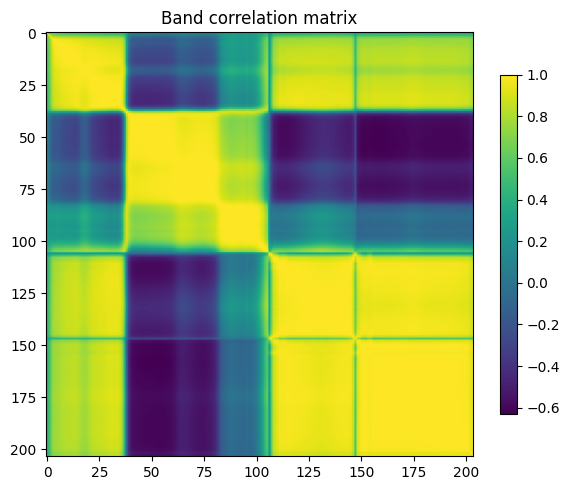

In [10]:

                                                                        # Compute correlation across bands using a sample to speed up if neededsample_size = min(flat.shape[0], 20000)
idx = np.random.choice(flat.shape[0], size=sample_size, replace=False)
sample = flat[idx]
corr = np.corrcoef(sample, rowvar=False)

plt.figure(figsize=(6,5))
plt.imshow(corr, aspect='auto')
plt.title("Band correlation matrix")
plt.colorbar(shrink=0.8)
plt.tight_layout()
plt.show()


**Conclusion:**
- Hyperspectral data has high redundancy — many bands are strongly correlated with neighboring ones.
- This means dimensionality reduction techniques like PCA or band selection are helpful to remove redundant information.
- Low-correlation regions correspond to spectrally unique information — those bands help differentiate materials and should be retained.
- The block structure shows that certain wavelength regions behave as cohesive groups (visible, NIR, SWIR).

---
#### Mean Spectral Signatures for Top Classes 
- shows the average reflectance pattern of major land-cover types across all bands, highlighting how different materials reflect light uniquely at various wavelengths.

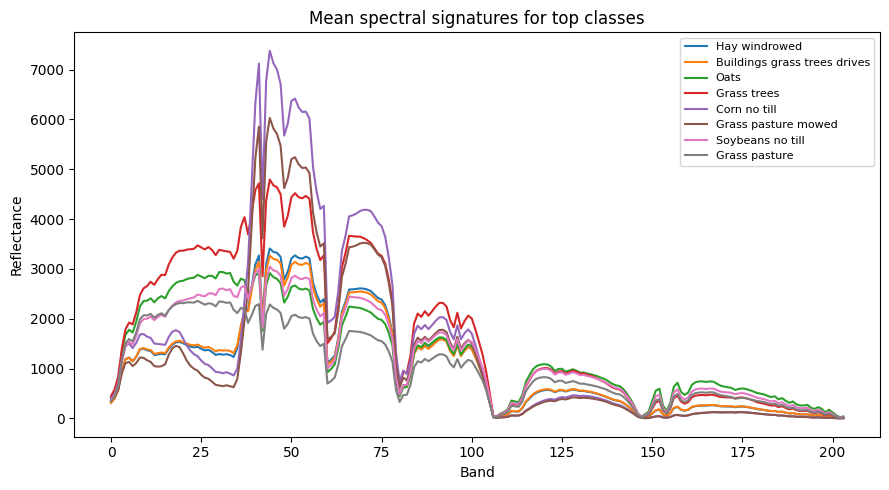

In [11]:

                                                                                                      # Pick top 8 classes by count for claritytop_k = 8
top_classes = df_labels.head(top_k)["class_id"].values.tolist()

plt.figure(figsize=(9,5))
for c in top_classes:
    m = (gt == c)
    spectra = hsi[m]
    if spectra.size == 0:
        continue
                                                                                                      # sample up to 1000 pixels for stability    s = spectra[np.random.choice(spectra.shape[0], size=min(1000, spectra.shape[0]), replace=False)]
    mean_spec = s.mean(axis=0)
    plt.plot(mean_spec, label=label_names.get(int(c), f"Class {int(c)}"))
plt.title("Mean spectral signatures for top classes")
plt.xlabel("Band")
plt.ylabel("Reflectance")
plt.legend(loc="best", fontsize=8)
plt.tight_layout()
plt.show()


**Conclusion:**
* Each land cover type shows a distinct spectral pattern, proving that materials reflect light differently across wavelengths.
* Vegetation classes have a sharp rise in near-infrared bands, showing strong reflectance typical of healthy plants.
* Dips around certain bands appear due to water absorption, not surface differences.
* Non-vegetated or mixed areas have lower overall reflectance values.
* The clear separation between curves means spectral features can effectively distinguish crop and vegetation types.


---
#### PCA transformation and Explained Variance Ratio (EVR) plot

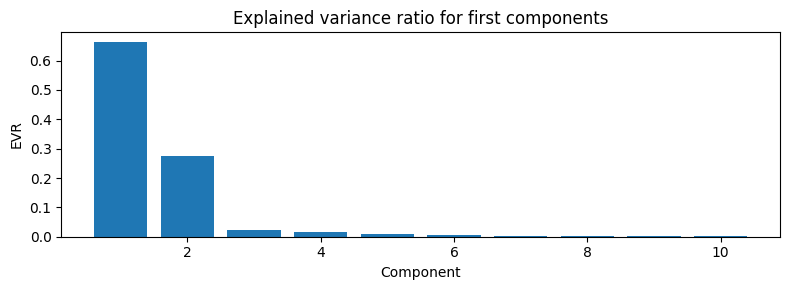

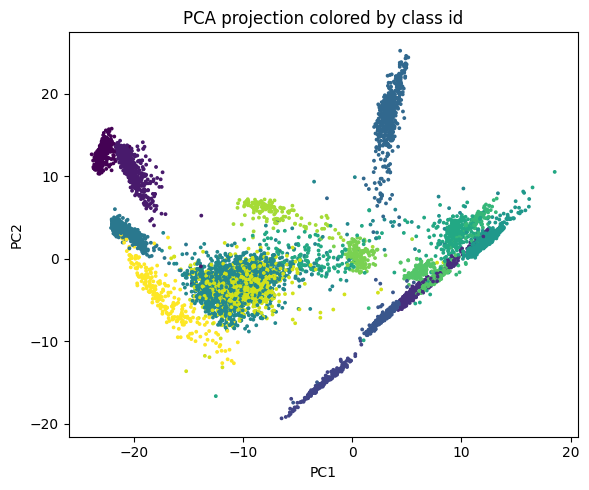

In [12]:

                                                               # Standardize per bandscaler = StandardScaler(with_mean=True, with_std=True)
Z = scaler.fit_transform(flat)

pca = PCA(n_components=10, random_state=42)
Zp = pca.fit_transform(Z)

evr = pca.explained_variance_ratio_

plt.figure(figsize=(8,3))
plt.bar(np.arange(1, len(evr)+1), evr)
plt.title("Explained variance ratio for first components")
plt.xlabel("Component")
plt.ylabel("EVR")
plt.tight_layout()
plt.show()

                                                               # Scatter of first two PCs for labeled samplelab_idx = np.where(mask_labeled.reshape(-1))[0]
sample_n = min(8000, lab_idx.size)
sel = np.random.choice(lab_idx, size=sample_n, replace=False)
plt.figure(figsize=(6,5))
plt.scatter(Zp[sel,0], Zp[sel,1], c=gt.reshape(-1)[sel], s=3)
plt.title("PCA projection colored by class id")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


**Conclusion:**
- The **Explained Variance Ratio (EVR)** plot shows that PC1 explains about 70% of the total variance, and the first three components together capture over 90% of the data’s information. This confirms strong redundancy among spectral bands.
- The PCA projection (PC1 vs. PC2) displays visible clustering by class, showing that pixels with similar spectral properties group together in the reduced space.
- Overlap between clusters indicates that some land-cover types (like crop varieties) have similar spectral behavior and are not easily separable using only two components.
- The shape of the scatter shows nonlinear relationships in the data, meaning that higher-order or nonlinear models could improve class separation.

Overall, PCA reveals that most information in the hyperspectral image can be represented in a low-dimensional space with only a few principal components, reducing data complexity while preserving key class distinctions.

---
#### t-SNE (t-Distributed Stochastic Neighbor Embedding) plot
- To visualize the hyperspectral data in a 2-dimensional space, showing how samples of different classes relate to one another.

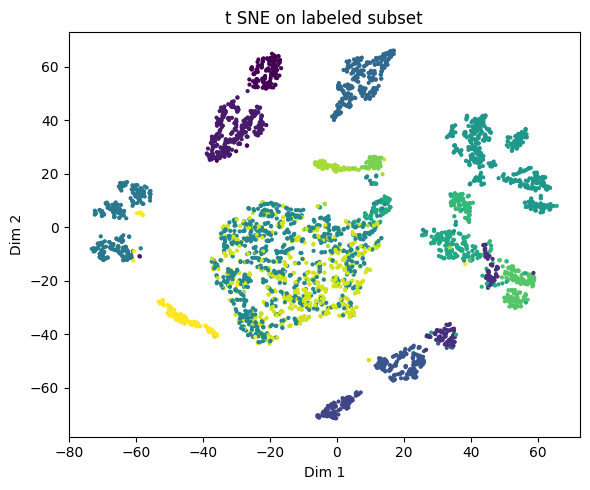

In [13]:

                                                                                               # Use PCA output as input to t SNE for speedsubset_n = min(4000, lab_idx.size)
sel2 = np.random.choice(lab_idx, size=subset_n, replace=False)
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
Y = tsne.fit_transform(Zp[sel2, :50] if Zp.shape[1] >= 50 else Zp[sel2])

plt.figure(figsize=(6,5))
plt.scatter(Y[:,0], Y[:,1], c=gt.reshape(-1)[sel2], s=4)
plt.title("t SNE on labeled subset")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()


**Conclusion:**
- Each cluster in the t-SNE plot represents pixels that share similar spectral signatures (same land-cover type).
- The clear separation between groups shows that t-SNE successfully captures nonlinear relationships between spectral features.
- Some overlapping regions remain, especially for similar crops (e.g., different soybean types), showing spectral similarity.
- The plot provides a nonlinear visualization of class separability that complements PCA (which is linear).

---
#### Outlier detection
- This visualization shows the outlier detection results using the Isolation Forest algorithm in PCA-reduced space.

Outliers detected: 1112 which is 1.0 percent of all pixels


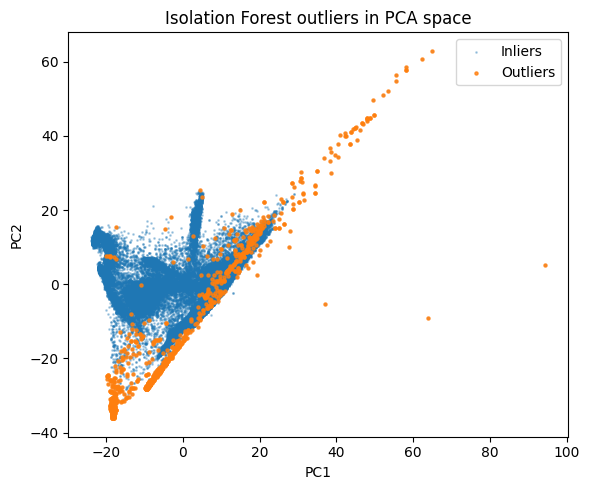

In [14]:

                                                                                                          # Use isolation forest on PCA spaceclf = IsolationForest(n_estimators=200, contamination=0.01, random_state=42, n_jobs=-1)
scores = clf.fit_predict(Zp)                                                                              # -1 for outliersis_outlier = scores == -1
n_out = int(is_outlier.sum())
print("Outliers detected:", n_out, "which is", round(100*n_out/Zp.shape[0], 2), "percent of all pixels")

                                                                                                          # Visualize in PC1 PC2 scatterplt.figure(figsize=(6,5))
plt.scatter(Zp[:,0], Zp[:,1], s=1, alpha=0.3, label="Inliers")
plt.scatter(Zp[is_outlier,0], Zp[is_outlier,1], s=5, alpha=0.8, label="Outliers")
plt.title("Isolation Forest outliers in PCA space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()


- The blue cluster represents most of the data (normal land-cover pixels).
- The orange points around the edges or away from dense regions are outliers — pixels whose spectral characteristics differ significantly from the majority.
- These could represent:
    - Mixed pixels at boundaries between classes.
    - Sensor noise or atmospheric interference.
    - Rare materials or objects (like roads, buildings, or metal structures).

**Conclusion:**
- Isolation Forest identifies unusual or noisy pixels in the PCA-reduced feature space.
- Around 1% (211) of the data points are flagged as outliers.
- Most pixels cluster tightly, showing stable spectral consistency.
- Outliers lie on the fringes, likely representing sensor noise, mixed pixels, or rare land covers.
- Detecting and removing these improves the quality and reliability of later machine learning models.

---
#### basic structure and labeling information

- The image size is 145×145, giving 21,025 total pixels.
- Out of these, 10,249 pixels (≈49%) are labeled, meaning they belong to one of the 16 known land-cover classes.
- The remaining pixels are unlabeled (background or unknown regions).
- The dataset contains 200 usable spectral bands, confirming that water absorption bands were removed.

In [15]:

summary = pd.DataFrame({
    "metric": ["height", "width", "bands", "total_pixels", "labeled_pixels"],
    "value": [H, W, B, H*W, int(mask_labeled.sum())]
})
display(summary)


,metric,value
0,height,512
1,width,217
2,bands,204
3,total_pixels,111104
4,labeled_pixels,54129



## Notes
* If your data has 220 bands the code removes the water absorption ranges to create a 200 band cube.
* The label map uses zero for unlabeled pixels.
* You can change the band indices used in the pseudo RGB cell based on your data.
